### Bayesian Neural Network

In [25]:
import theano
import pymc3 as pm
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [26]:
# dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# neural network / machine learning
from sklearn.neural_network import MLPClassifier

# methods metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [27]:
# MNIST dataset
import keras.datasets as datasets
import theano.tensor.nnet as nnet

from scipy.stats import mode

### MNIST Dataset  / data processing

#### Dimensionality Reduction

The caller of reduce_dimensionality can select which reducer method to use. 
If TSNE is chosen I decided to use a subset of the initial dataset with a default of 500 elements since the execution time takes much longer than it takes for PCA to finish.

In [28]:
def reduce_dimensionality(data, labels, nfeatures, reducer):
        algorithm = ""
        if reducer == 'PCA':
            algorithm = PCA(n_components=nfeatures)
            algorithm.fit(data)
            data = algorithm.transform(data)
            print("explained_variance_ratio_ {}".format(algorithm.explained_variance_ratio_.sum()))
        
        if reducer == 'TSNE':
            data, labels = (data[0:500], train_labels[0:500])
            algorithm = TSNE(n_components=2)
            data = algorithm.fit_transform(data)
        print("new total number of features: {}".format(nfeatures))
        print("current classes: {}".format(set(labels)))
        return data, labels

In [29]:
# display an image
def print_image(image, x = 28, y = 28):
    img = image.reshape((x, y))
    plt.imshow(img)

In [30]:
# use this function for various processing steps
def process_dataset(dataset):
    processed_ds = []
    for image in dataset:
        processed_ds.append(image.flatten())
    return np.array(processed_ds)

In [31]:
fashion_mnist = datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [32]:
train_images = process_dataset(train_images)
test_images = process_dataset(test_images)

In [33]:
print("shape of processed images: {}".format(train_images.shape))
print("shape of training labels: {}".format(train_labels.shape))

shape of processed images: (60000, 784)
shape of training labels: (60000,)


#### Binary Classification subset

Data processing for the binary classification. (NN vs Bayesian NN)
Since we have 10 classes a dataset composed by 2 classes (Trouser & T-Shirt) will be extracted. Why not dress and boots some would ask..? Well the reason is that there are pretty obvious

In [34]:
m1 = [(x, y) for x, y in zip(train_images, train_labels) if y == 1 or y == 0]
m2 = [(x, y) for x, y in zip(test_images, test_labels) if y == 1 or y == 0]

In [35]:
binary_train_x, binary_train_y = map(list, zip(*m1))
binary_test_x, binary_test_y = map(list, zip(*m2))

binary_train_x = np.array(binary_train_x)
binary_train_y = np.array(binary_train_y)

binary_test_x = np.array(binary_test_x)
binary_test_y = np.array(binary_test_y)

In [36]:
print("binary train data size: {}".format(len(binary_train_x)))
print("binary test data size: {}".format(len(binary_test_x)))
print("binary train_label data size: {}".format(len(binary_train_y)))
print("binary test_label data size: {}".format(len(binary_test_y)))

binary train data size: 12000
binary test data size: 2000
binary train_label data size: 12000
binary test_label data size: 2000


Cloth Number: 0


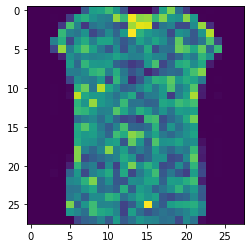

In [37]:
# for some arbitrary indexes verify that our subset has only the needed clothes
test_index = 11
print("Cloth Number: {}".format(binary_train_y[test_index]))
print_image(binary_train_x[test_index])

In [38]:
# for the scatter plot I will reduce the dimensionality to 2
xx, yy = reduce_dimensionality(train_images, train_labels, 5, 'PCA')

explained_variance_ratio_ 0.6161884303430186
new total number of features: 5
current classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


[0 1 2 3 4 5 6 7 8 9]


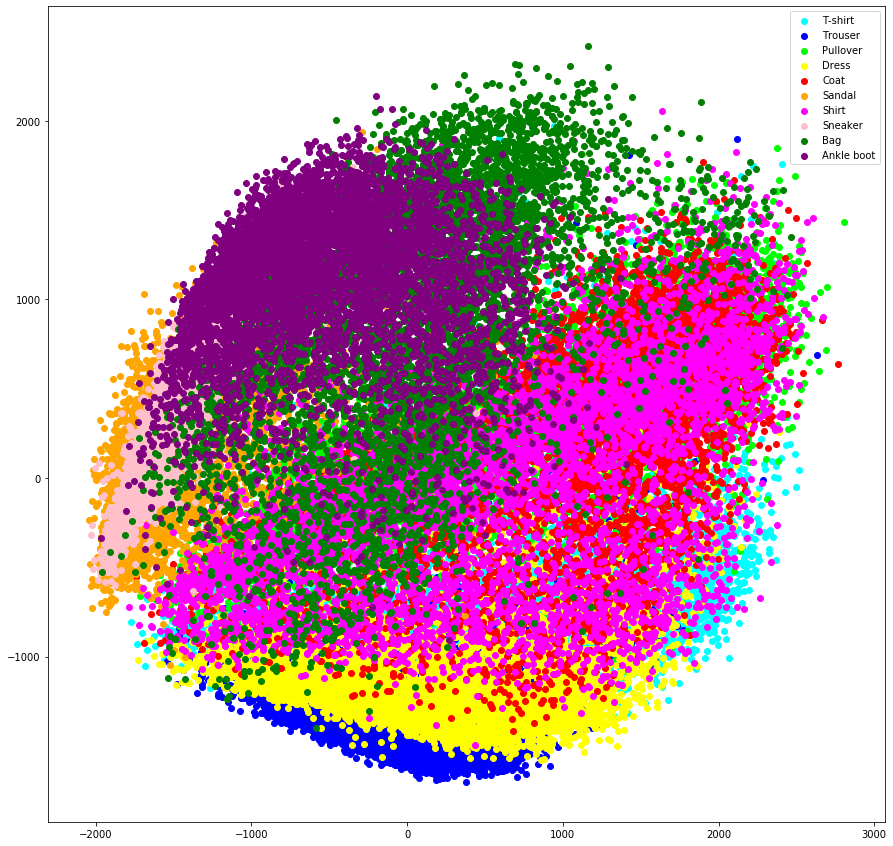

In [39]:
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
colors = ["cyan", "blue", "lime", "yellow", "red", "orange", "magenta", "pink", "green", "purple"]

def plot_pca_images(images, labels):
    plt.rcParams["figure.figsize"] = [15, 15]
    print(np.unique(labels.astype(np.int)))
    for k, i in enumerate(np.unique(labels)):
        plt.scatter(images[labels == i, 0],
                    images[labels == i, 1], 
                    color = colors[k],
                    label = classes[k])
    plt.legend()
    plt.show()

plot_pca_images(xx, yy)

### Binary Classification

### Neural Network

In [40]:
binary_train_x, binary_train_y = reduce_dimensionality(binary_train_x, binary_train_y, 100, 'PCA')
binary_test_x, binary_test_y = reduce_dimensionality(binary_test_x, binary_test_y, 100, 'PCA')

explained_variance_ratio_ 0.938398458849521
new total number of features: 100
current classes: {0, 1}
explained_variance_ratio_ 0.9443055283123121
new total number of features: 100
current classes: {0, 1}


In [41]:
print(binary_train_x.shape)
print(binary_test_x.shape)

(12000, 100)
(2000, 100)


In [42]:
binary_train_x = (binary_train_x /255).astype(theano.config.floatX)

#binary_train_x_subset = binary_train_x[0:4000]
#binary_train_y_subset = binary_train_y[0:4000]

binary_train_x_subset = binary_train_x
binary_train_y_subset = binary_train_y

#binary_test_x_subset = ((binary_test_x[0:1000] / 255).astype(theano.config.floatX))
binary_test_x_subset = (binary_test_x / 255).astype(theano.config.floatX)
#binary_test_y_subset = binary_test_y[0:1000]
binary_test_y_subset = binary_test_y

In [43]:
nn = MLPClassifier(hidden_layer_sizes=(32, 16, 16), 
                    max_iter=200,
                    learning_rate_init=0.001, solver='sgd', activation='relu',
                    alpha=0.002, verbose = True)

In [44]:
nn.fit(binary_train_x_subset, binary_train_y_subset)

Iteration 1, loss = 0.64138849
Iteration 2, loss = 0.50006039
Iteration 3, loss = 0.39510361
Iteration 4, loss = 0.30197722
Iteration 5, loss = 0.23248533
Iteration 6, loss = 0.18622526
Iteration 7, loss = 0.15575023
Iteration 8, loss = 0.13529673
Iteration 9, loss = 0.12073371
Iteration 10, loss = 0.10985619
Iteration 11, loss = 0.10129650
Iteration 12, loss = 0.09425783
Iteration 13, loss = 0.08829747
Iteration 14, loss = 0.08317903
Iteration 15, loss = 0.07880883
Iteration 16, loss = 0.07495699
Iteration 17, loss = 0.07166243
Iteration 18, loss = 0.06869581
Iteration 19, loss = 0.06610502
Iteration 20, loss = 0.06377014
Iteration 21, loss = 0.06172050
Iteration 22, loss = 0.05984950
Iteration 23, loss = 0.05815158
Iteration 24, loss = 0.05659117
Iteration 25, loss = 0.05521103
Iteration 26, loss = 0.05394214
Iteration 27, loss = 0.05278123
Iteration 28, loss = 0.05169616
Iteration 29, loss = 0.05066298
Iteration 30, loss = 0.04972602
Iteration 31, loss = 0.04883009
Iteration 32, los

MLPClassifier(activation='relu', alpha=0.002, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 16, 16), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [45]:
predictions = nn.predict(binary_test_x_subset)

In [46]:
print("Result of simple neural network: {}".format(accuracy_score(binary_test_y_subset, predictions)))
print("Confusion Matrix: \n{}".format(confusion_matrix(binary_test_y_subset, predictions)))

Result of simple neural network: 0.9465
Confusion Matrix: 
[[928  72]
 [ 35 965]]


### Bayesian Neural Network

In [47]:
binary_test_y_subset =  (binary_test_y_subset).astype(theano.config.floatX)
binary_train_y_subset = (binary_train_y_subset).astype(theano.config.floatX)

In [48]:
# Below are some key points about the model:
# - the model consists of 2 hiden layers;
# - we initialize the weights for each layer randomly;
# - for the first layer we take into consideration the number of initial neurons (#neurons = features in our image)
# - the number of neurons in each hidden layer (except the first one) is parameterized and equal 
#    -> the caller can call the construction function of the model with a given number of hidden neruons;
def construct_bnn(input_train_data, input_test_data, total_neurons=16):
    # First layer has 32 neurons and for the other layers we use a default of 16 neurons which can be overriden
    # The initialization of the random weights between each layer
    w_1 = np.random.randn(binary_train_x.shape[1], 32).astype(theano.config.floatX)
    w_2 = np.random.randn(32, total_neurons).astype(theano.config.floatX)
    w_3 = np.random.randn(total_neurons, total_neurons).astype(theano.config.floatX)
    w_out = np.random.randn(total_neurons).astype(theano.config.floatX)

    with pm.Model() as neural_network:

        # The weights between the input and the first hidden layer
        input_weights = pm.Normal('input_weights', shape=(binary_train_x.shape[1], 32), testval=w_1)

        # The weights between the first and the second hidden layer
        input_weights_to_2 = pm.Normal('input_weights_to_2', shape=(32, 16), testval=w_2)

        # The weights between the second and the third hidden layer
        w_2_to_3 = pm.Normal('w_2_to_3', shape=(total_neurons, total_neurons), testval=w_3)

        # The weights between the third and the output layer / the output layer has a total of features
        # equal to the number of classes.In this case the number of classes is equal to 2 due to the fact
        # that we want to execute a binary classification. Also the data was prepared for the binary classificaiton
        # model beforehand
        w_3_to_output = pm.Normal('w_3_to_output', shape=(total_neurons,), testval=w_out)

        # nnet.tanh... /pm.math.tanh
        # We used the sigmoid activation function for the output
        bnn_1 = nnet.relu(pm.math.dot(input_train_data, input_weights))
        bnn_2 = nnet.relu(pm.math.dot(bnn_1, input_weights_to_2))
        bnn_3 = nnet.relu(pm.math.dot(bnn_2, w_2_to_3))
        bnn_out = pm.math.sigmoid(pm.math.dot(bnn_3, w_3_to_output))

        # for Binary classification we need to use a Bernoulli distribution
        out = pm.Bernoulli('out',bnn_out,observed=input_test_data,total_size=binary_train_y.shape[0])
    return neural_network


In [49]:
inpt = theano.shared(binary_train_x_subset)
oupt = theano.shared(binary_train_y_subset)
bnn = construct_bnn(inpt, oupt)

In [50]:
with bnn:
    advi = pm.ADVI()
    
    # we use this tracker to return some insights about our model
    tracker = pm.callbacks.Tracker(
        mean=advi.approx.mean.eval,  
        std=advi.approx.std.eval 
    )
    approx = pm.fit(n=40000, method=advi, callbacks=[tracker])

trace = approx.sample(draws=5000)


Average Loss = 3,340: 100%|██████████| 40000/40000 [06:11<00:00, 107.66it/s]    
Finished [100%]: Average Loss = 3,331.2


Text(0.5, 0, 'iterations')

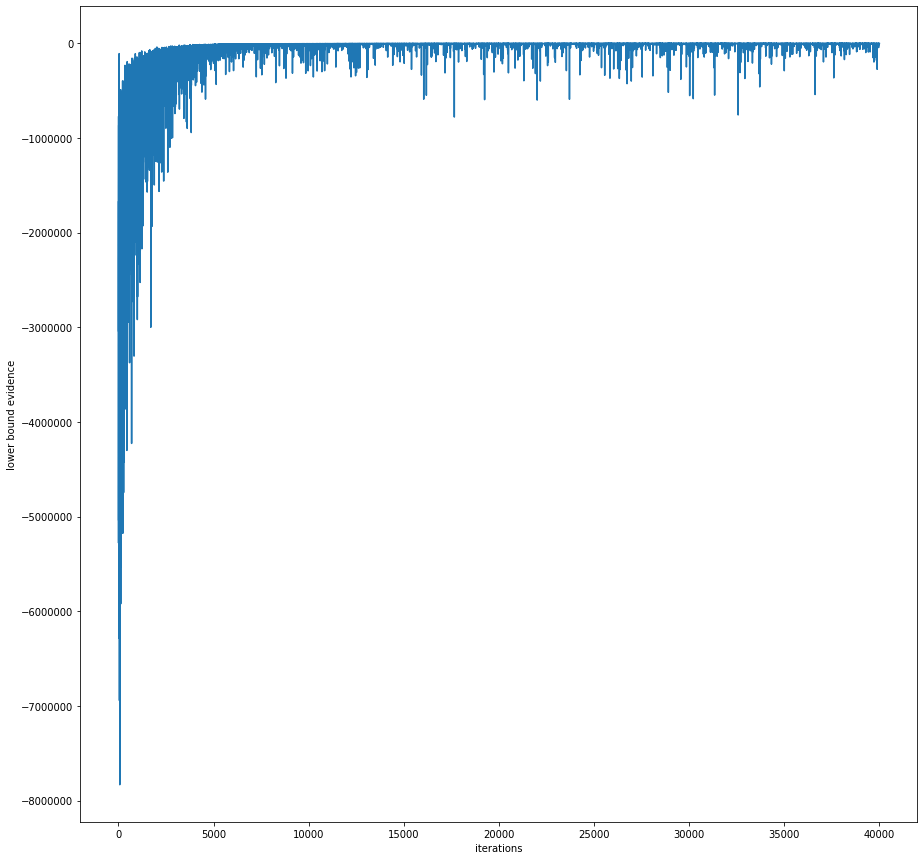

In [51]:
plt.plot(-advi.hist)
plt.ylabel('lower bound evidence')
plt.xlabel('iterations')

In [52]:
# Now let's see how our model handles the test data
inpt.set_value(binary_test_x_subset)
oupt.set_value(binary_test_y_subset)
with bnn:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=True)

prediction_result = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:06<00:00, 74.56it/s]


In [53]:
print('Prediction Accuracy: {}%'.format((binary_test_y_subset == prediction_result).mean() * 100))

Prediction Accuracy: 93.85%


### Binary Classification Conclusion

For both Bayesian-NN and NN I used the same architecture regarding the hidden layers. Each network had 3 hidden layers with a specific number of neurons in the following order: (32, 16, 16)

For the simple neural network, using the same number of hidden layers I obtained an accuracy of ~94.7%.
The simple neural network was created using MLPClassifier from the scikit library which is flexible enough to demonstrate our conclusions.

The Bayesian neural network model had an accuracy of ~94.85% on the same data. As we can see the results were quite similar, but for the latter the execution time took a little bit longer. I assumed that in order to identify a specific class I needed a probabiliy greater than 0.5 (ppc['out'].mean(axis=0) > 0.5).

The number of iterations in the Bayesian NN was set to 40.000 since the default of 10.000 was lower than needed.

In order to reduce the execution time I decided to reduce MNIST dataset's dimensionality to 100 features.
I prefered to test it without using mini-batches since there are only 2 classes so there's no need for overkilling it..

Since there are only 2 classes for the binary classification, the loss resulted from using PCA did not affect the final accuracy results.

## Multiclass Classification

In [54]:
multi_train_x, multi_train_y = reduce_dimensionality(train_images, train_labels, 50, 'PCA')
multi_test_x, multi_test_y = reduce_dimensionality(test_images, test_labels, 50, 'PCA')

explained_variance_ratio_ 0.8626436545628351
new total number of features: 50
current classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
explained_variance_ratio_ 0.8628871445705065
new total number of features: 50
current classes: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [55]:
test_images.shape

(10000, 784)

In [56]:
multi_train_x_subset = (train_images[0:30000] / 255).astype(theano.config.floatX)
multi_train_y_subset = train_labels[0:30000]

multi_test_x_subset = (test_images[0:5000] / 255).astype(theano.config.floatX)
multi_test_y_subset = test_labels[0:5000]

In [57]:
multi_train_y_subset.shape

(30000,)

In [58]:
multi_test_y_subset.shape

(5000,)

### Neural Network

In [59]:
multi_nn = MLPClassifier(hidden_layer_sizes=(32, 32), max_iter=300, 
                        learning_rate='adaptive', solver='sgd',
                        alpha=0.0003,
                        activation='relu', verbose = True)

In [60]:
multi_nn.fit(multi_train_x_subset, multi_train_y_subset)

Iteration 1, loss = 1.91788282
Iteration 2, loss = 1.25872360
Iteration 3, loss = 0.97204151
Iteration 4, loss = 0.84647541
Iteration 5, loss = 0.77255921
Iteration 6, loss = 0.72165180
Iteration 7, loss = 0.68223148
Iteration 8, loss = 0.65077037
Iteration 9, loss = 0.62378766
Iteration 10, loss = 0.60190583
Iteration 11, loss = 0.58270039
Iteration 12, loss = 0.56710005
Iteration 13, loss = 0.55381456
Iteration 14, loss = 0.54165174
Iteration 15, loss = 0.53177269
Iteration 16, loss = 0.52325464
Iteration 17, loss = 0.51436606
Iteration 18, loss = 0.50778513
Iteration 19, loss = 0.50055655
Iteration 20, loss = 0.49464795
Iteration 21, loss = 0.48895207
Iteration 22, loss = 0.48317261
Iteration 23, loss = 0.47903673
Iteration 24, loss = 0.47387270
Iteration 25, loss = 0.46966038
Iteration 26, loss = 0.46586683
Iteration 27, loss = 0.46201766
Iteration 28, loss = 0.45902157
Iteration 29, loss = 0.45555265
Iteration 30, loss = 0.45208602
Iteration 31, loss = 0.44889739
Iteration 32, los

Iteration 253, loss = 0.26755369
Iteration 254, loss = 0.26669603
Iteration 255, loss = 0.26620167
Iteration 256, loss = 0.26640100
Iteration 257, loss = 0.26609778
Iteration 258, loss = 0.26576406
Iteration 259, loss = 0.26503142
Iteration 260, loss = 0.26442566
Iteration 261, loss = 0.26379968
Iteration 262, loss = 0.26395970
Iteration 263, loss = 0.26293951
Iteration 264, loss = 0.26245367
Iteration 265, loss = 0.26253409
Iteration 266, loss = 0.26184046
Iteration 267, loss = 0.26139384
Iteration 268, loss = 0.26113850
Iteration 269, loss = 0.26080173
Iteration 270, loss = 0.26043840
Iteration 271, loss = 0.25916114
Iteration 272, loss = 0.26008045
Iteration 273, loss = 0.25908837
Iteration 274, loss = 0.25872881
Iteration 275, loss = 0.25879393
Iteration 276, loss = 0.25856132
Iteration 277, loss = 0.25747257
Iteration 278, loss = 0.25757670
Iteration 279, loss = 0.25700254
Iteration 280, loss = 0.25720974
Iteration 281, loss = 0.25628710
Iteration 282, loss = 0.25538471
Iteration 

/Users/lucian.nut/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0003, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(32, 32), learning_rate='adaptive',
              learning_rate_init=0.001, max_iter=300, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [61]:
prediction = multi_nn.predict(multi_test_x_subset)

In [62]:
print("Result of simple neural network: {}\n".format(accuracy_score(multi_test_y_subset, prediction)))
print("Confusion Matrix: \n{}".format(confusion_matrix(multi_test_y_subset, prediction)))

Result of simple neural network: 0.8636

Confusion Matrix: 
[[435   1  10  19   3   0  34   0   5   0]
 [  1 466   1  11   1   1   0   0   0   0]
 [ 10   1 417  11  54   0  26   1   1   0]
 [ 21   4   9 434  13   0  12   0   7   0]
 [  0   0  56  23 414   0  26   0   2   0]
 [  1   0   0   1   0 457   0  17   2   7]
 [ 74   1  62  20  41   0 278   0   6   0]
 [  0   0   0   0   0  10   0 482   0   8]
 [  5   2   5   5   4   3   4   6 492   0]
 [  0   0   0   1   0   5   0  27   1 443]]


### Bayesian Neural Network

In [63]:
multi_test_y_subset = multi_test_y_subset
multi_train_y_subset = multi_train_y_subset

In [64]:
multi_test_y_subset= multi_test_y_subset.astype(theano.config.floatX)
multi_train_y_subset= multi_train_y_subset.astype(theano.config.floatX)

In [65]:
def construct_multiclass_bnn(input_train_data, input_test_data, input_shape = multi_train_x_subset.shape[1]
                            ,output_shape=multi_train_y_subset.shape[0], output_neurons=10):
    total_neurons = 32

    # Initialize random weights between each layer
    w_1 = np.random.randn(input_shape, total_neurons).astype(theano.config.floatX)
    w_2 = np.random.randn(total_neurons, total_neurons).astype(theano.config.floatX)
    w_3 = np.random.randn(total_neurons, total_neurons).astype(theano.config.floatX)

    w_out = np.random.randn(total_neurons, output_neurons).astype(theano.config.floatX)

    with pm.Model() as m_bnn:

        # The weights between the input and the first hidden layer
        input_weights = pm.Normal('input_weights', sigma=0.3, 
                                 shape=(input_shape, total_neurons), testval=w_1)

        # The weights between the first and the second hidden layer
        weights_1_2 = pm.Normal('weights_1_2',sigma=0.3, shape=(total_neurons, total_neurons), testval=w_2)

        # The weights between the second and the third hidden layer
        weights_2_3 = pm.Normal('weights_2_3',sigma=0.3, shape=(total_neurons, total_neurons), testval=w_3)

        # The weights between the third and the output hidden layer
        weights_3_out = pm.Normal('weights_3_out',sigma=0.3, shape=(total_neurons,output_neurons), testval=w_out)

        # Build neural-network using relu activation function
        act_1 = pm.math.tanh(pm.math.dot(input_train_data, input_weights))
        act_2 = pm.math.tanh(pm.math.dot(act_1, weights_1_2))
        act_3 = pm.math.tanh(pm.math.dot(act_2, weights_2_3))
        act_out = nnet.softmax(pm.math.dot(act_3, weights_3_out))
   
        # Multi classification -> We use Categorical instead of Bernoulli
        out = pm.Categorical('out',act_out,observed=input_test_data,total_size=output_shape)
    return m_bnn

In [66]:
multi_train_x_subset_mini_batch = pm.Minibatch(multi_train_x_subset, batch_size = 15)
multi_train_y_subset_mini_batch = pm.Minibatch(multi_train_y_subset, batch_size = 15)

/Users/lucian.nut/opt/anaconda3/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [67]:
bayesian_neural_network_multiclass = construct_multiclass_bnn(multi_train_x_subset_mini_batch, multi_train_y_subset_mini_batch)

In [68]:
with bayesian_neural_network_multiclass:
    advi_inference = pm.ADVI()
    approx = pm.fit(n=40000, method=advi_inference)

Average Loss = 686.76: 100%|██████████| 40000/40000 [04:00<00:00, 166.24it/s] 
Finished [100%]: Average Loss = 686.52


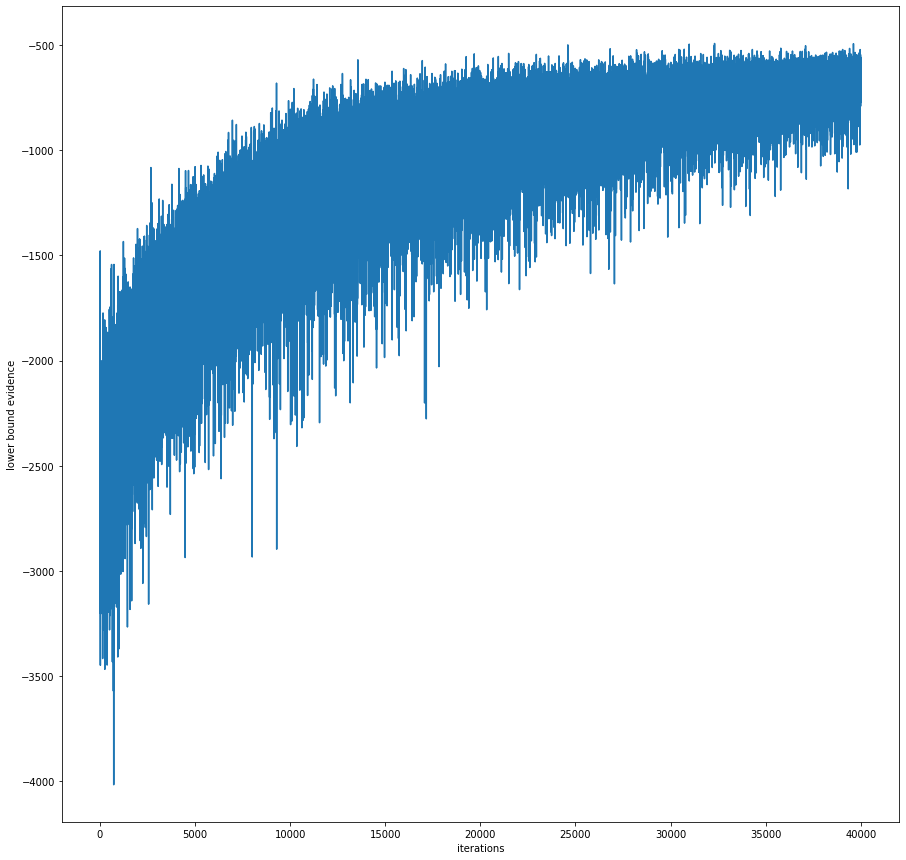

In [69]:
plt.plot(-advi_inference.hist)
plt.ylabel('lower bound evidence')
plt.xlabel('iterations');

In [70]:
samples = approx.sample_node(bayesian_neural_network_multiclass.out.distribution.p,
                             size = 1000, 
                             more_replacements = {multi_train_x_subset_mini_batch : multi_test_x_subset})

prediction_result = samples.eval().mean(0)

/Users/lucian.nut/opt/anaconda3/lib/python3.7/site-packages/theano/scan_module/scan_perform_ext.py:76: UserWarning: The file scan_perform.c is not available. This donot happen normally. You are probably in a strangesetup. This mean Theano can not use the cython code for scan. If youwant to remove this warning, use the Theano flag'cxx=' (set to an empty string) to disable all ccode generation.
  "The file scan_perform.c is not available. This do"


In [71]:
axis_nr = 1

In [72]:
print('Accuracy:{}%'.format((multi_test_y_subset == np.argmax(prediction_result, axis=axis_nr)).mean()*100))

Accuracy:10.639999999999999%


### Multi class classification conclusion

For the multiclass demonstration I used the entire daset containing all 10 classes of clothes.
I extracted 30k out of the 60k entries for the training data and 5k out of the 10k test values.
The values were already randomly shuffled so the extraction is a subset from 0 to n, where n is the number of elements we need.

Since this would normally be insanely slow I also divided the train data into minibatches.

The simple neural network which was created using the same class from scikit library (MLPClassifier) has 2 layers with 32 neurons each. The same architecture was used for the Bayesian-NN aswell.

After tweaking the hyperparameters using grid search I managed to obtain an accuracy score around ~85%-87% for the simple NN on multiple classes. 

Without the mini-batches the execution time would take an insane amount of time. I also reduced the dimensionality to 50 using PCA.

The precision obtained with Bayesian Neural Network is somwehere around 12% which is not as good as the result for the simple NN in the multiclass classification comparison.